In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from sys import platform as sys_pf
# if sys_pf == 'darwin':
#     import matplotlib
#     matplotlib.use("TkAgg")
! pip install simpleitk
%matplotlib inline  
import os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import SimpleITK as sitk
from scipy import ndimage
import random
import math


     |████████████████████████████████| 42.5MB 78kB/s 


In [0]:
image_shape = (256,256,176)

# Read in transformed images
def read_file(filename):
    data = np.loadtxt(filename, delimiter=",")
    data = np.reshape(data,image_shape)
    return data

# Read in non-transformed images
def read_original(filename):
    reader = sitk.ImageFileReader()
    reader.SetImageIO("NiftiImageIO")
    reader.SetFileName(filename)
    image = reader.Execute()

    # img1 = sitk.ReadImage(folder + item)  # alternative way to pull in image

    # convert image into np array & perform fft
    img = sitk.GetArrayFromImage(image)
    # Transpose the image so the first axis is Anterior-Posterior
    img = np.transpose(img, (2,1,0))
    return img 

def visualize(orig, new):
    plt.figure(figsize= (20,20))
    plt.subplot(121), plt.imshow(orig, cmap='gray')
    plt.title('Original'), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(new, cmap='gray')
    plt.title('New'), plt.xticks([]), plt.yticks([])
    
def visualize3(orig, blur, predict):
    plt.figure(figsize= (30,30))
    plt.subplot(131), plt.imshow(orig, cmap='gray')
    plt.title('Original'), plt.xticks([]), plt.yticks([])
    plt.subplot(132), plt.imshow(blur, cmap='gray')
    plt.title('Blurred'), plt.xticks([]), plt.yticks([])
    plt.subplot(133), plt.imshow(predict, cmap='gray')
    plt.title('Predicted'), plt.xticks([]), plt.yticks([])

In [0]:
new = read_file('gdrive/My Drive/NU_Rad/transforms/M02_motion5_trans.txt.gz')
orig = read_original('gdrive/My Drive/NU_Rad/mris/M02.nii')


(Text(0.5, 1.0, 'New'),
 ([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

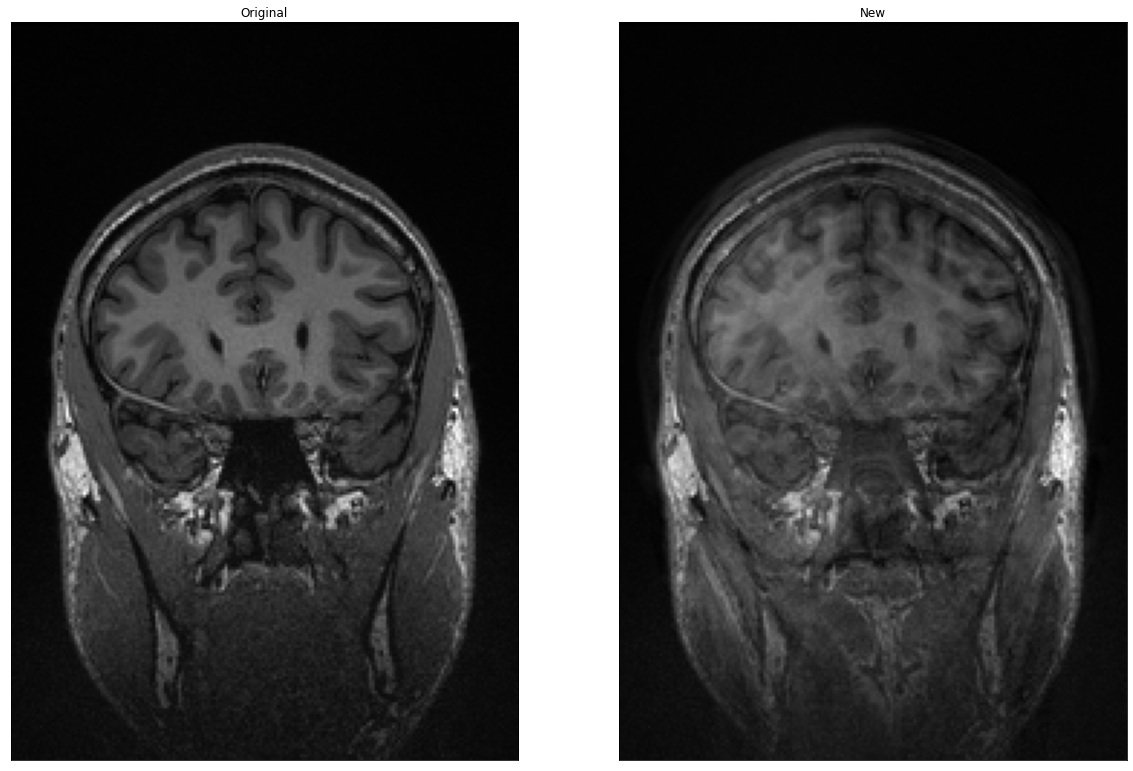

In [0]:
slc = 100
plt.figure(figsize= (20,20))
plt.subplot(121), plt.imshow(orig[slc], cmap='gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(new[slc], cmap='gray')
plt.title('New'), plt.xticks([]), plt.yticks([])

In [0]:
print(np.amax(orig[100]))
print(np.amax(new[100]))
print(np.amin(orig[100]))
print(np.amin(new[100]))
print(orig.shape)
print(new.shape)

690
630.0639475349228
0
0.04791501606443611
(256, 256, 176)
(256, 256, 176)


In [0]:
#   Preprocessing
# Data- Slice range from 70 to 220
# Flatten each image
# keras.utils.normalize each image
# reshape back

#   Architecture

# Input layer

# 2d convolution
# activation- relu
# 2d convlution
# activation- relu

# loss = mse


# TO DO-
# Double check the normalization function by multiplying output slice by max val & visualizing
# Put together full pipeline taking in all mris
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Concatenate, Add, Average, Input, Dense, Flatten, BatchNormalization, Activation, LeakyReLU, Reshape
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D
from tensorflow.keras import backend as K
import tensorflow.keras.callbacks as callbacks
import tensorflow.keras.optimizers as optimizers
from sklearn import preprocessing as prepro
from sklearn.model_selection import train_test_split

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

Using TensorFlow backend.


In [0]:
# Normalizes each image slice
def norm_slices (data):    
    orig_shape = np.shape(data)
    new_shape = np.reshape(data, (list(orig_shape)[0], list(orig_shape)[1] * list(orig_shape)[2]))
    new_shape_norm = tf.keras.utils.normalize(new_shape, axis=0, order=2)
    return np.reshape(new_shape_norm, orig_shape)


def generate_data(t_filenames, o_filenames, min_slc = 70, max_slc = 220):
    # Takes in the files of the transformed images and the originals to create the pairs
    # Also sets the min and max slice numbers to take in
    x_data = []
    y_data = []
    for i in range(len(t_filenames)):
        print('Generating data for: ' + t_filenames[i])
        x_mri = read_file(t_filenames[i])
        y_mri = read_original(o_filenames[i])
        for ii in np.arange(min_slc, max_slc+1):
            x_data.append(x_mri[ii]/np.amax(x_mri[ii])) # normalizes the intensity to between 0 and 1
            y_data.append(y_mri[ii]/np.amax(y_mri[ii]))
    # Shape of x & y will be [# slices, 256, 176, 1]
    x_data = np.array(x_data)[..., np.newaxis]
    y_data = np.array(y_data)[..., np.newaxis]
    return x_data, y_data

In [0]:
trans_folder = 'gdrive/My Drive/NU_Rad/transforms/'
orig_folder = 'gdrive/My Drive/NU_Rad/mris/'
X_filenames = []
y_filenames = []
for item in os.listdir(trans_folder):
    if item.endswith("_trans.txt.gz"):
        X_filenames.append(trans_folder + item)
        y_filenames.append(orig_folder + item[:3] + '.nii')

# X, y = generate_data(['gdrive/My Drive/NU_Rad/transforms/M02_motion5_trans.txt.gz'], ['gdrive/My Drive/NU_Rad/mris/M02.nii'])
X, y = generate_data(X_filenames, y_filenames)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Generating data for: gdrive/My Drive/NU_Rad/transforms/M02_motion5_trans.txt.gz
Generating data for: gdrive/My Drive/NU_Rad/transforms/M02_motion3_trans.txt.gz
Generating data for: gdrive/My Drive/NU_Rad/transforms/M02_motion4_trans.txt.gz
Generating data for: gdrive/My Drive/NU_Rad/transforms/M02_motion1_trans.txt.gz
Generating data for: gdrive/My Drive/NU_Rad/transforms/M02_motion2_trans.txt.gz
Generating data for: gdrive/My Drive/NU_Rad/transforms/M01_motion5_trans.txt.gz
Generating data for: gdrive/My Drive/NU_Rad/transforms/M01_motion3_trans.txt.gz
Generating data for: gdrive/My Drive/NU_Rad/transforms/M01_motion4_trans.txt.gz
Generating data for: gdrive/My Drive/NU_Rad/transforms/M03_motion5_trans.txt.gz
Generating data for: gdrive/My Drive/NU_Rad/transforms/M03_motion3_trans.txt.gz
Generating data for: gdrive/My Drive/NU_Rad/transforms/M03_motion4_trans.txt.gz
Generating data for: gdrive/My Drive/NU_Rad/transforms/M03_motion1_trans.txt.gz
Generating data for: gdrive/My Drive/NU_

In [0]:
X = np.reshape(X/854., (3473, 256, 176, 1))
y = np.reshape(y/854., (3473, 256, 176, 1))

In [0]:
print(np.shape(X))
print(np.shape(X_train))

(3473, 256, 176, 1)
(2326, 256, 176, 1)


In [0]:
# first troubleshooting network

model = Sequential()
model.add(Conv2D(64, (5,5), padding='same', input_shape = X.shape[1:]))
model.add(Activation("relu"))

model.add(Conv2D(64, (3,3), padding='same'))
model.add(Activation("relu"))

model.add(Dense(64))
model.add(Dense(1))
model.add(Reshape((256,176)))

model.compile(loss="mean_squared_error", optimizer="adam", metrics=['accuracy'])
model.fit(X, y, batch_size=10, validation_split=0.1, epochs = 10)

Train on 3125 samples, validate on 348 samples
Epoch 1/10
3125/3125 [==============================] - 20s 6ms/sample - loss: 1761.1443 - acc: 0.4350 - val_loss: 1134.7977 - val_acc: 0.5470
Epoch 2/10
3125/3125 [==============================] - 19s 6ms/sample - loss: 1533.4634 - acc: 0.5241 - val_loss: 1139.4010 - val_acc: 0.5710
Epoch 3/10
3125/3125 [==============================] - 19s 6ms/sample - loss: 1494.2002 - acc: 0.5326 - val_loss: 1120.0829 - val_acc: 0.5696
Epoch 4/10
3125/3125 [==============================] - 19s 6ms/sample - loss: 1480.9851 - acc: 0.5337 - val_loss: 1407.4116 - val_acc: 0.5648
Epoch 5/10
3125/3125 [==============================] - 19s 6ms/sample - loss: 1477.2289 - acc: 0.5316 - val_loss: 1115.7356 - val_acc: 0.5624
Epoch 6/10
3125/3125 [==============================] - 19s 6ms/sample - loss: 1473.4952 - acc: 0.5304 - val_loss: 1238.3644 - val_acc: 0.5686
Epoch 7/10
3125/3125 [==============================] - 19s 6ms/sample - loss: 1450.0417 - acc:

In [0]:
# Simple unet with mse loss

def conv_layer(dim1, dim2):
    # abstracted a single conv layer out since the parameters outside of dimension were kept the same
    return Conv2D(dim1, dim2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')

# u_net model
def unet_model(lr= 1e-4,input_size = (256, 176, 1)):
    dropout_level = 0.1

    inputs = Input(input_size)

    conv1 = conv_layer(64, 3)(inputs)
    conv1 = conv_layer(64, 3)(conv1)
    drop1 = Dropout(dropout_level)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(drop1)
    conv2 = conv_layer(128, 3)(pool1)
    conv2 = conv_layer(128, 3)(conv2)
    drop2 = Dropout(dropout_level)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(drop2)
    conv3 = conv_layer(256, 3)(pool2)
    conv3 = conv_layer(256, 3)(conv3)
    drop3 = Dropout(dropout_level)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)
    conv4 = conv_layer(512, 3)(pool3)
    conv4 = conv_layer(512, 3)(conv4)
    drop4 = Dropout(dropout_level)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    conv5 = conv_layer(1024, 3)(pool4)
    conv5 = conv_layer(1024, 3)(conv5)
    drop5 = Dropout(dropout_level)(conv5)

    # Decoder
    up6 = conv_layer(512, 2)(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    drop6 = Dropout(dropout_level)(merge6)
    conv6 = conv_layer(512, 3)(drop6)
    conv6 = conv_layer(512, 3)(conv6)
    
    up7 = conv_layer(256, 2)(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    drop7 = Dropout(dropout_level)(merge7)
    conv7 = conv_layer(256, 3)(drop7)
    conv7 = conv_layer(256, 3)(conv7)

    up8 = conv_layer(128, 2)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    drop8 = Dropout(dropout_level)(merge8)
    conv8 = conv_layer(128, 3)(drop8)
    conv8 = conv_layer(128, 3)(conv8)

    up9 = conv_layer(64, 2)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    drop9 = Dropout(dropout_level)(merge9)
    conv9 = conv_layer(64, 3)(drop9)
    conv9 = conv_layer(64, 3)(conv9)
    conv9 = conv_layer(2, 3)(conv9)
    conv10 = Conv2D(1, 1, activation = 'linear')(conv9)

    model = Model(input = inputs, output = conv10)
    model.compile(loss="mean_squared_error", optimizer="adam")
    return model

In [0]:
# Checkpoint
check_path = 'gdrive/My Drive/NU_Rad/models/unet_mse_model'
checkpoint = ModelCheckpoint(check_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

model = unet_model()
model.fit(X, y, batch_size=10, validation_split=0.1, epochs = 3, use_multiprocessing=True, callbacks=callbacks_list)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Train on 3125 samples, validate on 348 samples
Epoch 1/3
3125/3125 [==============================] - 99s 32ms/step - loss: 0.0342 - val_loss: 0.0278

Epoch 00001: val_loss improved from inf to 0.02777, saving model to gdrive/My Drive/NU_Rad/models/unet_mse_model
Epoch 2/3
3125/3125 [==============================] - 98s 31ms/step - loss: 0.0257 - val_loss: 0.0277

Epoch 00002: val_loss improved from 0.02777 to 0.02774, saving model to gdrive/My Drive/NU_Rad/models/unet_mse_model
Epoch 3/3
3125/3125 [==============================] - 98s 31ms/step - loss: 0.0257 - val_loss: 0.0277

Epoch 00003: val_loss did not improve from 0.02774


In [0]:
# list out layers names for VGG19
vgg19 = VGG19(include_top=False, weights='imagenet')
vgg19.summary()
print(vgg19.layers)

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [0]:
# u_net with perceptual loss
# perceptual loss function from https://github.com/deepak112/Keras-SRGAN/blob/master/Utils_model.py

from keras.applications.vgg19 import VGG19
import keras.backend as K
from keras.models import Model
from keras.optimizers import Adam

class VGG_LOSS(object):

    def __init__(self, image_shape):
        
        self.image_shape = image_shape
        self.layers_to_extract = [5,10,15,20]

    # computes VGG loss or content loss
    def vgg_loss(self, y_true, y_pred):
    
        vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=self.image_shape)
        vgg19.trainable = False
        # Make trainable as False
        for l in vgg19.layers:
            l.trainable = False
        model = Model(inputs=vgg19.input, outputs=vgg19.get_layer('block5_conv4').output)
        model.trainable = False
        return K.mean(K.square(model(K.concatenate((y_true, y_true, y_true), axis=-1)) - model(K.concatenate((y_pred, y_pred, y_pred),axis=-1)))) * 1e08

    # Using all layers of the VGG output
    def vgg_loss_all(self, y_true, y_pred):
        vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=self.image_shape)
        vgg19.trainable = False
        # Make trainable as False
        for l in vgg19.layers:
            l.trainable = False
        model = Model(inputs=vgg19.input, outputs=[vgg19.get_layer(index=i).output for i in self.layers_to_extract])
        model.trainable = False

        # have to triple the input because vgg takes in RGB samples and our data is grayscale
        preds = model(K.concatenate((y_pred, y_pred, y_pred), axis=-1))
        trues = model(K.concatenate((y_true, y_true, y_true), axis=-1))

        sums = 0
        # calculate mse for each of the output layers
        for i in range(len(preds)):
            sums += K.mean(K.square(trues[i] - preds[i]))
        return (sums/len(preds)) * 1e05
    
def get_optimizer():
 
    adam = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    return adam

def unet_pl_model(lr= 1e-4,input_size = (256, 176, 1)):
    dropout_level = 0.1

    inputs = Input(input_size)

    conv1 = conv_layer(64, 3)(inputs)
    conv1 = conv_layer(64, 3)(conv1)
    drop1 = Dropout(dropout_level)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(drop1)
    conv2 = conv_layer(128, 3)(pool1)
    conv2 = conv_layer(128, 3)(conv2)
    drop2 = Dropout(dropout_level)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(drop2)
    conv3 = conv_layer(256, 3)(pool2)
    conv3 = conv_layer(256, 3)(conv3)
    drop3 = Dropout(dropout_level)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)
    conv4 = conv_layer(512, 3)(pool3)
    conv4 = conv_layer(512, 3)(conv4)
    drop4 = Dropout(dropout_level)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    conv5 = conv_layer(1024, 3)(pool4)
    conv5 = conv_layer(1024, 3)(conv5)
    drop5 = Dropout(dropout_level)(conv5)

    # Decoder
    up6 = conv_layer(512, 2)(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    drop6 = Dropout(dropout_level)(merge6)
    conv6 = conv_layer(512, 3)(drop6)
    conv6 = conv_layer(512, 3)(conv6)
    
    up7 = conv_layer(256, 2)(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    drop7 = Dropout(dropout_level)(merge7)
    conv7 = conv_layer(256, 3)(drop7)
    conv7 = conv_layer(256, 3)(conv7)

    up8 = conv_layer(128, 2)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    drop8 = Dropout(dropout_level)(merge8)
    conv8 = conv_layer(128, 3)(drop8)
    conv8 = conv_layer(128, 3)(conv8)

    up9 = conv_layer(64, 2)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    drop9 = Dropout(dropout_level)(merge9)
    conv9 = conv_layer(64, 3)(drop9)
    conv9 = conv_layer(64, 3)(conv9)
    conv9 = conv_layer(2, 3)(conv9)
    conv10 = Conv2D(1, 1, activation = 'linear')(conv9)

    model = Model(input = inputs, output = conv10)

    loss = VGG_LOSS(input_size[0:2] + (3,))

    # model.compile(loss=loss.vgg_loss, optimizer="adam") # one vgg layer
    model.compile(loss=loss.vgg_loss_all, optimizer="adam")
    return model

In [0]:
# Checkpoint
check_path = 'gdrive/My Drive/NU_Rad/models/unet_pl_ml_check_model'
checkpoint = ModelCheckpoint(check_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

# u_pl_model = unet_pl_model()
u_pl_model.fit(X, y, batch_size=10, validation_split=0.2, epochs = 10, use_multiprocessing=True, callbacks=callbacks_list)

Train on 2778 samples, validate on 695 samples
Epoch 1/10
2778/2778 [==============================] - 640s 231ms/step - loss: 0.1194 - val_loss: 0.1322

Epoch 00001: val_loss improved from inf to 0.13221, saving model to gdrive/My Drive/NU_Rad/models/unet_pl_ml_check_model
Epoch 2/10
2778/2778 [==============================] - 641s 231ms/step - loss: 0.1122 - val_loss: 0.1408

Epoch 00002: val_loss did not improve from 0.13221
Epoch 3/10
2778/2778 [==============================] - 640s 231ms/step - loss: 0.1073 - val_loss: 0.1280

Epoch 00003: val_loss improved from 0.13221 to 0.12799, saving model to gdrive/My Drive/NU_Rad/models/unet_pl_ml_check_model
Epoch 4/10
2778/2778 [==============================] - 640s 231ms/step - loss: 0.1038 - val_loss: 0.1287

Epoch 00004: val_loss did not improve from 0.12799
Epoch 5/10
2778/2778 [==============================] - 640s 231ms/step - loss: 0.1003 - val_loss: 0.1203

Epoch 00005: val_loss improved from 0.12799 to 0.12029, saving model t

In [0]:
u_pl_model.save('gdrive/My Drive/NU_Rad/models/unet_pl_ml_model.h5')

In [0]:
X_predict, y_predict = generate_data(['gdrive/My Drive/NU_Rad/transforms/M02_motion5_trans.txt.gz'], ['gdrive/My Drive/NU_Rad/mris/M02.nii'])

Generating data for: gdrive/My Drive/NU_Rad/transforms/M02_motion5_trans.txt.gz


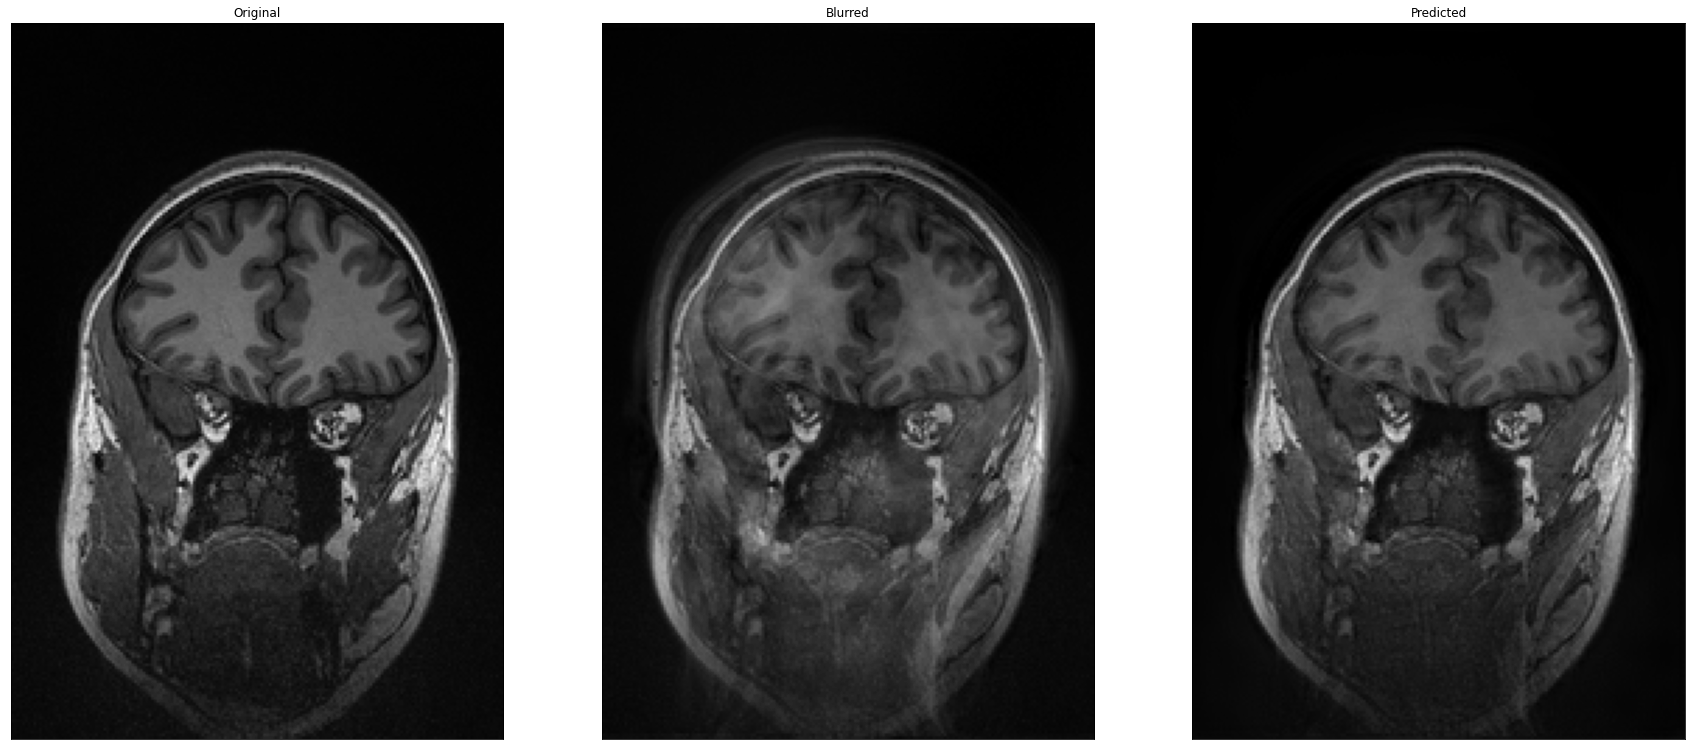

In [0]:
# test on a validation image from 'unet_pl_ml_model.h5'
ind = 120

# train_input = X[ind]
train_input = X_test[ind]
train_out = u_pl_model.predict(np.array(train_input[np.newaxis, ...]))

# visualize3(y[ind][...,0], train_input[...,0], train_out[0,...,0])
visualize3(y_test[ind][...,0], train_input[...,0], train_out[0,...,0])

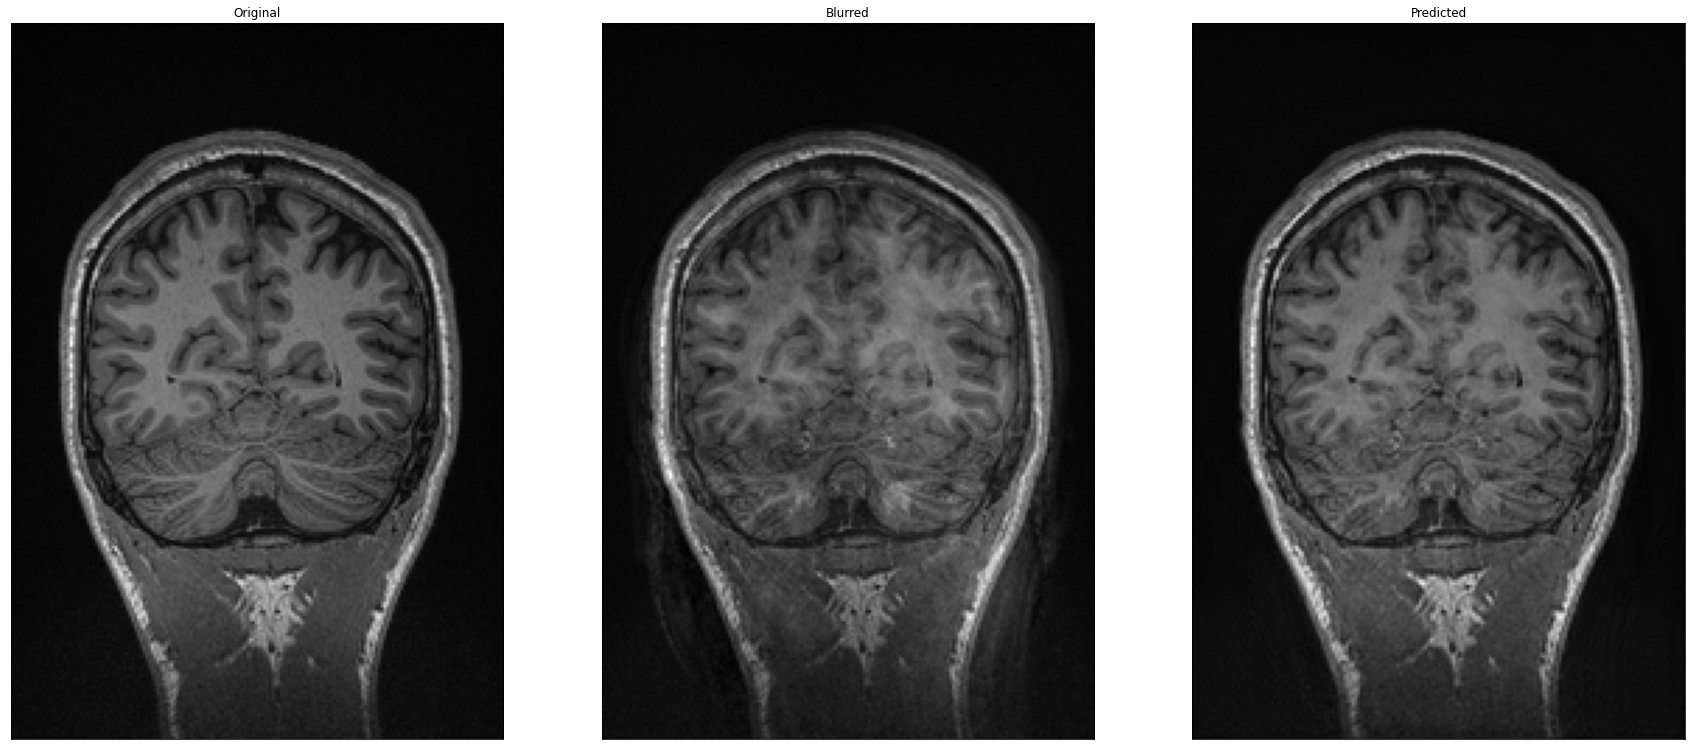

In [0]:
# test on a training image from model 'unet_pl_model.h5'
ind = 120

train_input = X[ind]
train_out = u_pl_model.predict(np.array(train_input[np.newaxis, ...]))

visualize3(y[ind][...,0], train_input[...,0], train_out[0,...,0])

In [0]:
np.amax(train_input)

0.683251496861104

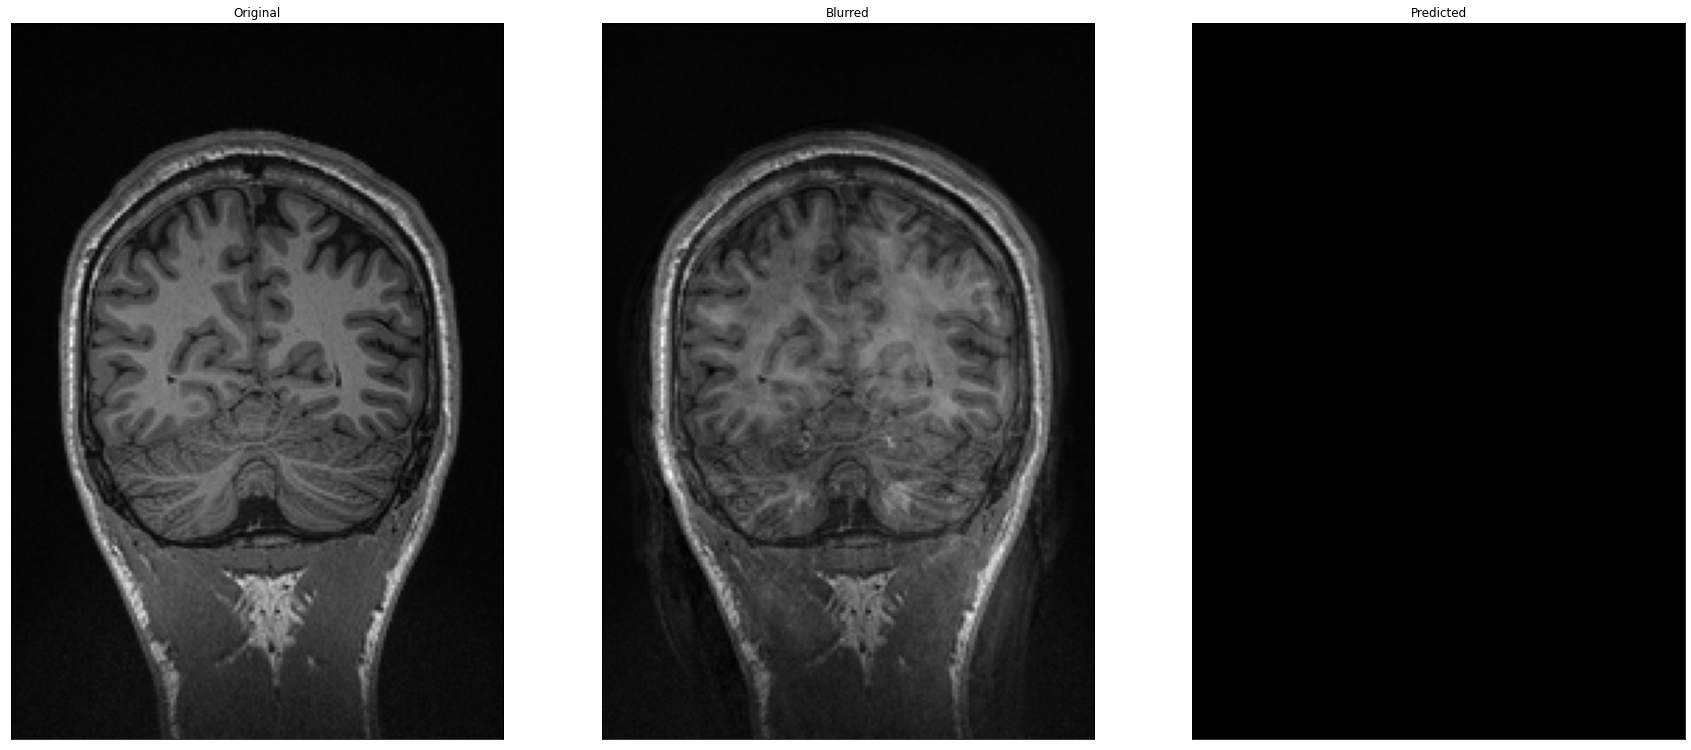

In [0]:
# Results from unet

predict_slice = 120
X_input = np.reshape(X_predict[predict_slice]/854., (1, 256, 176, 1))
predict_out = model.predict(np.array(X_input))

output = np.reshape(predict_out, (256, 176))
# output = output*690
visualize3(y_predict[predict_slice]/854., X_predict[predict_slice], output)

In [0]:
np.shape(X)

(3473, 256, 176, 1)

In [0]:
np.shape(y)

(3473, 256, 176)

In [0]:
testmot = motion('gdrive/My Drive/NU_Rad/motion/motion1.dat')

NameError: ignored

In [0]:
mod1 = read_file('gdrive/My Drive/NU_Rad/transforms/M01_motion1_trans_1mod.txt.gz')
orig1 = read_original('gdrive/My Drive/NU_Rad/mris/M01.nii')

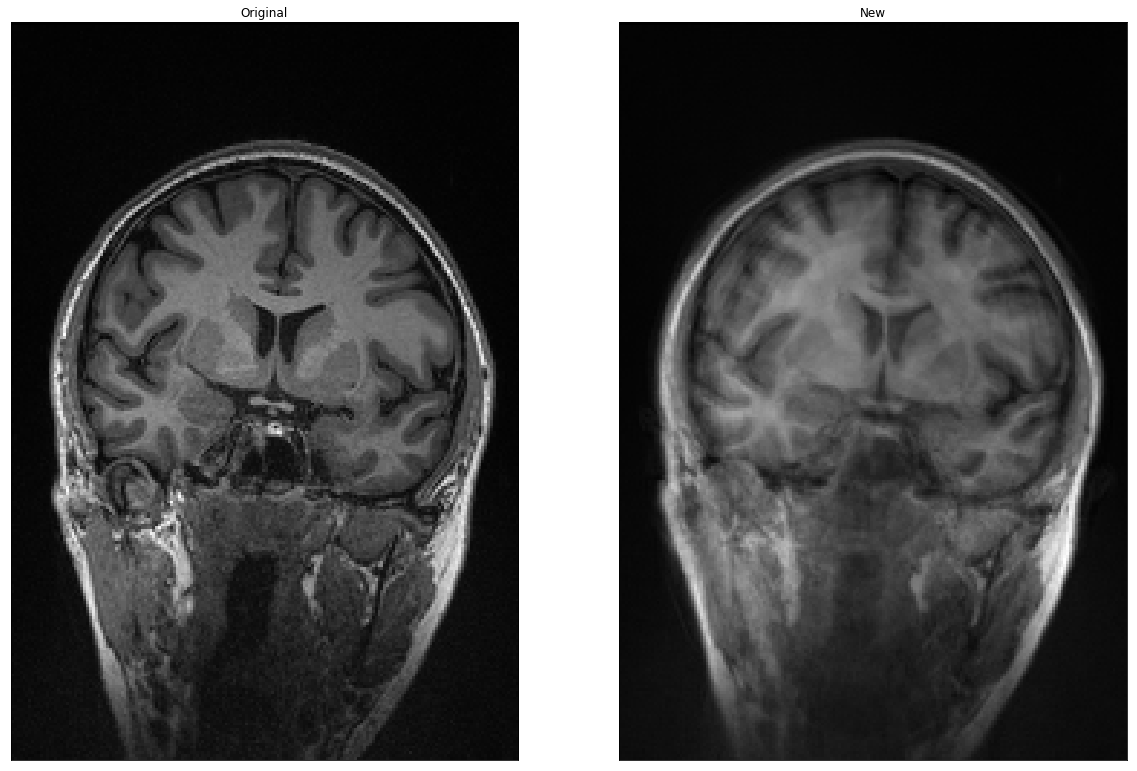

In [0]:
visualize(orig1[120],mod1[120])